In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import nltk
from nltk.tokenize import word_tokenize

import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

os.chdir("/Users/janieboettcher/Desktop/cs224n/project/cs224n_final_project/")

# Dataset description
Using train and test datasets, create bar graphs comparing the following
* frequency of question types
* context lengths 
* question lengths
* answer lengths 


In [ ]:
dev_truth = pd.read_json("data/dev_eval.json").T
dev_truth = dev_truth.rename(columns={"uuid":"Id"})
train_truth = pd.read_json("data/train_eval.json").T
train_truth = train_truth.rename(columns={"uuid":"Id"})
train_truth.head()

,answers,context,question,spans,Id
1,[in the late 1990s],Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"[[0, 7], [8, 15], [16, 23], [23, 24], [24, 30]...",56be85543aeaaa14008c9063
2,[singing and dancing],Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"[[0, 7], [8, 15], [16, 23], [23, 24], [24, 30]...",56be85543aeaaa14008c9065
3,[2003],Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"[[0, 7], [8, 15], [16, 23], [23, 24], [24, 30]...",56be85543aeaaa14008c9066
4,"[Houston, Texas]",Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"[[0, 7], [8, 15], [16, 23], [23, 24], [24, 30]...",56bf6b0f3aeaaa14008c9601
5,[late 1990s],Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"[[0, 7], [8, 15], [16, 23], [23, 24], [24, 30]...",56bf6b0f3aeaaa14008c9602


In [ ]:
# Question types 
qtypes = ["who", "when", "where", "what", "why", "which", "how"]
def qtype(question):
    question_list = question.lower().split()
    for qtype in qtypes:
        if qtype in question_list:
            return qtype
    return "other"
    
def create_q_types(df):
    questions = list(df.question)
    df["question_type"] = df.question.apply(lambda x: qtype(x))
    return df

def ave_ans_len(df):
    # WE WILL MAKE ANSWER LENGTHS TO BE AVERAGE
    result=[]
    answers = list(df.answers)
    for ans in answers:
        if len(ans) > 0:
            result.append(np.mean([len(a) for a in ans]))
        else:
            result.append(0)
    df["ave_ans_len"]=result
    return df


In [ ]:
qtypes = ["who", "when", "where", "what", "why", "which", "how"]
improved_qtypes = ["person", "date", "thing", "location", "quantity", "description", "other"]


def determine_by_qword(question_list):
    if "who" in question_list:
        return ["person"]
    elif "when" in question_list:
        return ["date"]
    elif "where" in question_list:
        return ["location"]
    elif "why" in question_list:
        return ["description"]
    elif "how" in question_list:
        i = question_list.index("how")
    elif "what" in question_list:
        i = question_list.index("what")
    elif "which" in question_list:
        i = question_list.index("which")
    else:
        return ["other"]
    if i < len(question_list)-1:
        return [question_list[i], question_list[i+1], i]
    return ["other"]

def determine_by_nextword(q_type):
    if q_type[0] != "how":
        loc_words = ["city", "state", "place", "country",
             "countries", "cities", "states", "places", 
             "areas", "area", "region", "regions", 
             "buildings", "building", "county", "counties"]
        
        if q_type[1] in loc_words:
            return ["location"]

        date_words = ["date", "year", "month", "day", 
              "dates", "years", "months", "days", 
              "hour", "hours", "decade", "decades", 
              "millennium", "millennia", "time", "times", 
              "era", "eras"]
        
        if q_type[1] in date_words:
            return ["date"]
    else:
        qnt_words = ["much", "many", "long", "far", "heavy", "light", "short"]
        if q_type[1] in qnt_words:
            return ["quantity"]
        else:
            tokenized = word_tokenize(q_type[0]+" "+q_type[1])
            tokenized = nltk.pos_tag(tokenized)
            if tokenized[1][1][:2] == 'VB':
                return ["description"]
            else:
                return ["quantity"]
    
    return q_type
    

def improved_qtype(question):
    question_list = question.lower().split()
    q_type = determine_by_qword(question_list)
    if len(q_type) == 1:
        #print(q_type[0])
        return q_type[0]
    q_type = determine_by_nextword(q_type)
    if len(q_type) == 1:
        #print(q_type[0])
        return q_type[0]
    return None


def improved_qtype_context(question, context, answers):
    q_type = improved_qtype(question)
    if q_type:
        return q_type
    
    result_dict = {"PERSON":"person",
                   "NORP": "person",
                   "FAC": "location",
                   "GPE": "location",
                   "LOC": "location",
                   "EVENT": "location",
                   "ORG": "thing",
                   "PRODUCT": "thing",
                   "WORK_OF_ART": "thing",
                   "LAW": "thing",
                   "LANGUAGE": "thing",
                   "ORDINAL": "thing",
                   "DATE": "date",
                   "TIME": "date",
                   "PERCENT": "quantity",
                   "MONEY": "quantity",
                   "QUANTITY": "quantity",
                   "CARDINAL": "quantity"}
                   
    if len(answers) > 0:
        doc = nlp(context)
        ent_text = [e.text for e in doc.ents]
        ent_label = [e.label_ for e in doc.ents]
        for ans in answers:
            if ans in ent_text:
                ent_type = ent_label[ent_text.index(ans)]
                if ent_type in result_dict:
                    return result_dict[ent_type]
    return "thing"


In [ ]:
improved_qtype("What place was that?")

'location'

In [ ]:
improved_qtype_context("What was the name of the first president?","The first president was George Washington. He was super cool.",["Washington","George Washington"])

'person'

In [ ]:
def create_updated_q_types(df):
    df['updated_question_type'] = df.apply(lambda x: improved_qtype_context(x.question,x.context,x.answers), axis=1)
    return df

In [ ]:
def categorize_by_entity(context, answers):          
    if len(answers) > 0:
        doc = nlp(context)
        ent_text = [e.text for e in doc.ents]
        ent_label = [e.label_ for e in doc.ents]
        for ans in answers:
            if ans in ent_text:
                return ent_label[ent_text.index(ans)]
    return "OTHER"

In [ ]:
def create_ans_types(df):
    df['ans_types'] = df.apply(lambda x: categorize_by_entity(x.context,x.answers), axis=1)
    return df

In [ ]:
def add_features(df):
    df = create_q_types(df)
    df = create_updated_q_types(df)
    df = create_ans_types(df)
    df["question_length"] = df.question.apply(lambda x: len(x))
    df["context_length"] = df.context.apply(lambda x: len(x))
    df=ave_ans_len(df)
    return df

In [ ]:
dev_truth = create_q_types(dev_truth)

In [ ]:
train_truth = create_q_types(train_truth)

In [ ]:
dev_truth = create_updated_q_types(dev_truth)

In [ ]:
dev_truth = create_ans_types(dev_truth)

In [ ]:
dev_truth["question_length"] = dev_truth.question.apply(lambda x: len(x))
dev_truth["context_length"] = dev_truth.context.apply(lambda x: len(x))
dev_truth=ave_ans_len(dev_truth)

In [ ]:
dev_truth.head()

,answers,context,question,spans,Id,question_type,updated_question_type,ans_types,question_length,context_length,ave_ans_len
1,"[France, France, France, France]",The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,"[[0, 3], [4, 11], [12, 13], [13, 19], [19, 20]...",68cf05f67fd29c6f129fe2fb9,what,location,GPE,36,742,6.00
2,"[10th and 11th centuries, in the 10th and 11th...",The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,"[[0, 3], [4, 11], [12, 13], [13, 19], [19, 20]...",f5fead9187d56af2bdbfcb921,when,date,OTHER,34,742,24.75
3,"[Denmark, Iceland and Norway, Denmark, Iceland...",The Normans (Norman: Nourmands; French: Norman...,From which countries did the Norse originate?,"[[0, 3], [4, 11], [12, 13], [13, 19], [19, 20]...",f9183ead5bb93aaa12ea37245,which,location,OTHER,45,742,27.00
4,"[Rollo, Rollo, Rollo, Rollo]",The Normans (Norman: Nourmands; French: Norman...,Who was the Norse leader?,"[[0, 3], [4, 11], [12, 13], [13, 19], [19, 20]...",1fc4da46445c2c1c2dc0ddeda,who,person,PERSON,25,742,5.00
5,"[10th century, the first half of the 10th cent...",The Normans (Norman: Nourmands; French: Norman...,What century did the Normans first gain their ...,"[[0, 3], [4, 11], [12, 13], [13, 19], [19, 20]...",1be9fa378cbee6d9fa8b6ac78,what,date,DATE,64,742,13.50


In [ ]:
train_truth["question_length"] = train_truth.question.apply(lambda x: len(x))
train_truth["context_length"] = train_truth.context.apply(lambda x: len(x))
train_truth=ave_ans_len(train_truth)

In [ ]:
train_truth.head()

,answers,context,question,spans,Id,question_type,question_length,context_length,ave_ans_len
1,[in the late 1990s],Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"[[0, 7], [8, 15], [16, 23], [23, 24], [24, 30]...",56be85543aeaaa14008c9063,when,40,694,17.0
2,[singing and dancing],Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"[[0, 7], [8, 15], [16, 23], [23, 24], [24, 30]...",56be85543aeaaa14008c9065,when,58,694,19.0
3,[2003],Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"[[0, 7], [8, 15], [16, 23], [23, 24], [24, 30]...",56be85543aeaaa14008c9066,when,64,694,4.0
4,"[Houston, Texas]",Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"[[0, 7], [8, 15], [16, 23], [23, 24], [24, 30]...",56bf6b0f3aeaaa14008c9601,what,45,694,14.0
5,[late 1990s],Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"[[0, 7], [8, 15], [16, 23], [23, 24], [24, 30]...",56bf6b0f3aeaaa14008c9602,which,42,694,10.0


In [ ]:
train_truth.head()

,answers,context,question,spans,Id,question_type,question_length,context_length,ave_ans_len
1,[in the late 1990s],Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"[[0, 7], [8, 15], [16, 23], [23, 24], [24, 30]...",56be85543aeaaa14008c9063,when,40,694,17.0
2,[singing and dancing],Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"[[0, 7], [8, 15], [16, 23], [23, 24], [24, 30]...",56be85543aeaaa14008c9065,when,58,694,19.0
3,[2003],Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"[[0, 7], [8, 15], [16, 23], [23, 24], [24, 30]...",56be85543aeaaa14008c9066,when,64,694,4.0
4,"[Houston, Texas]",Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"[[0, 7], [8, 15], [16, 23], [23, 24], [24, 30]...",56bf6b0f3aeaaa14008c9601,what,45,694,14.0
5,[late 1990s],Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"[[0, 7], [8, 15], [16, 23], [23, 24], [24, 30]...",56bf6b0f3aeaaa14008c9602,which,42,694,10.0


In [ ]:
# Plot frequency of question types
dev_qfreq = pd.DataFrame(dev_truth["question_type"].value_counts(normalize=True))
train_qfreq = pd.DataFrame(train_truth["question_type"].value_counts(normalize=True))
qfreq = dev_qfreq.merge(train_qfreq, left_index=True, right_index=True)
qfreq.set_axis(['dev', 'train'], axis=1, inplace=True)


Text(0, 0.5, 'Frequency')

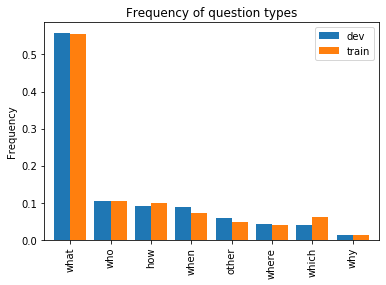

In [ ]:

#qfreq = dev_qfreq.merge(train_qfreq, left_index=True, right_index=True).set_axis(['dev', 'train'], axis=1)
qfreq.plot(kind="bar", width=0.8)
plt.title("Frequency of question types")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

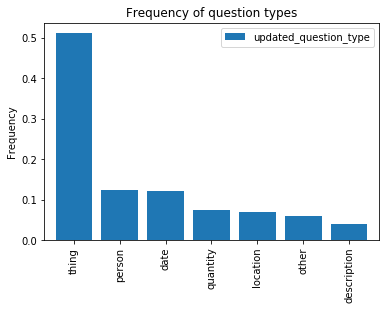

In [ ]:
# Plot frequency of updated question types
dev_new_qfreq = pd.DataFrame(dev_truth["updated_question_type"].value_counts(normalize=True))

dev_new_qfreq.plot(kind="bar", width=0.8)
plt.title("Frequency of question types")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

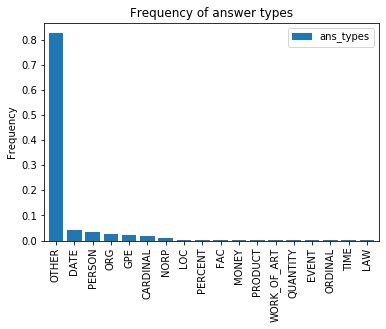

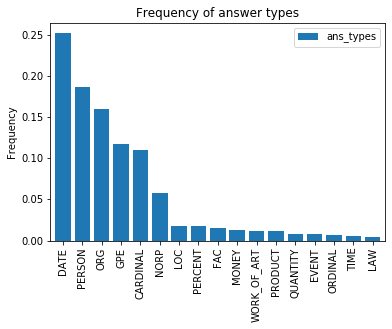

In [ ]:
# Plot frequency of entity answer types
dev_new_qfreq = pd.DataFrame(dev_truth["ans_types"].value_counts(normalize=True))

dev_new_qfreq.plot(kind="bar", width=0.8)
plt.title("Frequency of answer types")
plt.ylabel("Frequency")

new_try = dev_truth.loc[dev_truth["ans_types"] != "OTHER"]
dev_new_qfreq = pd.DataFrame(new_try["ans_types"].value_counts(normalize=True))

dev_new_qfreq.plot(kind="bar", width=0.8)
plt.title("Frequency of answer types")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

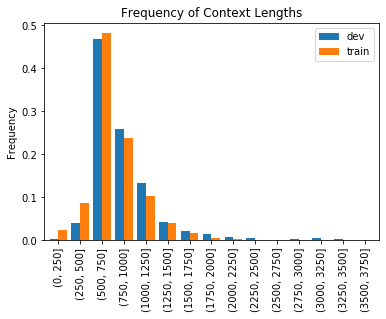

In [ ]:
# context lengths
bins = list(range(0, 4000, 250))
dev_contlen = pd.DataFrame(pd.cut(dev_truth.context_length, bins=bins).value_counts(normalize=True, sort=False))
train_contlen = pd.DataFrame(pd.cut(train_truth.context_length, bins=bins).value_counts(normalize=True, sort=False))
contlen = dev_contlen.merge(train_contlen,left_index=True, right_index=True)
contlen.set_axis(['dev', 'train'], axis=1, inplace=True)
contlen.plot(kind="bar", width=0.8)
plt.title("Frequency of Context Lengths")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

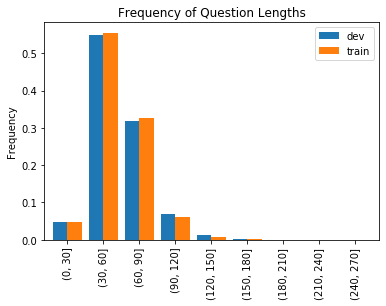

In [ ]:
# question lengths
bins = list(range(0, 300, 30))
dev_contlen = pd.DataFrame(pd.cut(dev_truth.question_length, bins=bins).value_counts(normalize=True, sort=False))
train_contlen = pd.DataFrame(pd.cut(train_truth.question_length, bins=bins).value_counts(normalize=True, sort=False))
contlen = dev_contlen.merge(train_contlen,left_index=True, right_index=True)
contlen.set_axis(['dev', 'train'], axis=1, inplace=True)
contlen.plot(kind="bar", width=0.8)
plt.title("Frequency of Question Lengths")
plt.ylabel("Frequency")



Text(0, 0.5, 'Frequency')

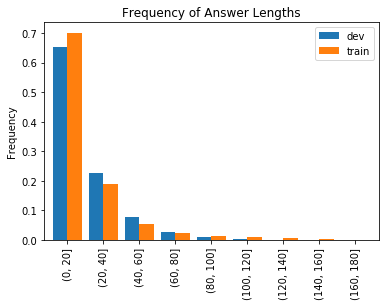

In [ ]:
# answer lengths
bins = list(range(0, 200, 20))
dev_contlen = pd.DataFrame(pd.cut(dev_truth.ave_ans_len, bins=bins).value_counts(normalize=True, sort=False))
train_contlen = pd.DataFrame(pd.cut(train_truth.ave_ans_len, bins=bins).value_counts(normalize=True, sort=False))
contlen = dev_contlen.merge(train_contlen,left_index=True, right_index=True)
contlen.set_axis(['dev', 'train'], axis=1, inplace=True)
contlen.plot(kind="bar", width=0.8)
plt.title("Frequency of Answer Lengths")
plt.ylabel("Frequency")


# Calculate EM and F1 scores 
Create functions (or use and modify from utils) to calculate EM and F1 scores for any set of predictions and ground truths. 


In [ ]:
# Code adapted from utils.py
import logging
import os
import queue
import re
import shutil
import string
import torch
import torch.nn.functional as F
import torch.utils.data as data
import tqdm
import numpy as np
import ujson as json

from collections import Counter

def eval_dicts(gold_dict, pred_dict, no_answer):
    avna = f1 = em = total = 0
    for key, value in pred_dict.items():

        total += 1
        ground_truths = gold_dict[key]['answers']
        prediction = value["answers"]
            
        em += metric_max_over_ground_truths(compute_em, prediction, ground_truths)
        f1 += metric_max_over_ground_truths(compute_f1, prediction, ground_truths)
        if no_answer:

            avna += compute_avna(prediction, ground_truths)

    eval_dict = {'EM': 100. * em / total,
                 'F1': 100. * f1 / total}
    
    if no_answer:
        eval_dict['AvNA'] = 100. * avna / total

    return eval_dict


def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    if not ground_truths:
        return metric_fn(prediction, '')
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)

def compute_avna(prediction, ground_truths):
    """Compute answer vs. no-answer accuracy."""
    return float(bool(prediction) == bool(ground_truths))


# All methods below this line are from the official SQuAD 2.0 eval script
# https://worksheets.codalab.org/rest/bundles/0x6b567e1cf2e041ec80d7098f031c5c9e/contents/blob/
def normalize_answer(s):
    """Convert to lowercase and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
        return re.sub(regex, ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()
    
    return white_space_fix(remove_articles(remove_punc(lower(s))))


def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()


def compute_em(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))


def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = Counter(gold_toks) & Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


In [ ]:
##############

def performance(pred_df, truth_df, name):
    
    pred_df = pred_df.set_index("Id")
    pred_dict = pred_df.rename({'Predicted':'answers'}, axis=1)
    pred_dict = pred_dict.fillna('').to_dict('index')
    
    truth_df = truth_df.set_index("Id")
    truth_dict = truth_df.to_dict("index")

    data = eval_dicts(truth_dict, pred_dict, True)
    result = pd.DataFrame.from_dict(data, orient="index").rename({0: name}, axis=1)
    
    return result

def q_type_performance(pred_df, truth_large_df):
    truth_df = truth_large_df[["answers", "Id"]]
    df = performance(pred_df, truth_df, "overall")
    qtypes = ["who", "when", "where", "what", "why", "which", "how", "other"]
    
    for qtype in qtypes:
        truth_q_df = truth_large_df[truth_large_df.question_type==qtype][["answers", "Id"]]
        pred_q_df = pred_df[pred_df.Id.isin(list(truth_q_df.Id))]
        result = performance(pred_q_df, truth_q_df, qtype)
        df = pd.merge(df,result, left_index=True, right_index=True)
        
    return df 

def new_q_type_performance(pred_df, truth_large_df):
    truth_df = truth_large_df[["answers", "Id"]]
    df = performance(pred_df, truth_df, "overall")
    improved_qtypes = ["person", "date", "thing", "location", "quantity", "description","other"]
    
    for qtype in improved_qtypes:
        truth_q_df = truth_large_df[truth_large_df.updated_question_type==qtype][["answers", "Id"]]
        pred_q_df = pred_df[pred_df.Id.isin(list(truth_q_df.Id))]
        result = performance(pred_q_df, truth_q_df, qtype)
        df = pd.merge(df,result, left_index=True, right_index=True)
        
    return df 

def ans_type_performance(pred_df, truth_large_df):
    truth_df = truth_large_df[["answers", "Id"]]
    df = performance(pred_df, truth_df, "overall")
    ans_types = ["PERSON","NORP","FAC","GPE","LOC","EVENT","ORG","PRODUCT","WORK_OF_ART","LAW","LANGUAGE",
"ORDINAL","DATE","TIME","PERCENT","MONEY","QUANTITY","CARDINAL","OTHER"]
    
    for qtype in ans_types:
        truth_q_df = truth_large_df[truth_large_df.ans_types==qtype][["answers", "Id"]]
        if len(truth_q_df.index)>0:
            pred_q_df = pred_df[pred_df.Id.isin(list(truth_q_df.Id))]
            result = performance(pred_q_df, truth_q_df, qtype)
            df = pd.merge(df,result, left_index=True, right_index=True)

    return df 



# Analysis 
We want to compare 4 models: baseline BIDAF, BIDAF w/ character embeddings, QANet-1, QANet-2. 


Here we want to see where our models perform well and perform poorly, using our dev sets.  More specifically, we want to see break down of F1, EM, AvNA score based on **question types**.

In [ ]:
bidaf_pred_df = pd.read_csv("save/test/baseline.dev.performance-01/dev_submission.csv")
bidaf_qtype = q_type_performance(bidaf_pred_df, dev_truth)
bidaf_qtype

,overall,who,when,where,what,why,which,how,other
EM,57.939842,59.649123,64.990689,57.254902,56.807935,47.674419,65.898618,54.151625,58.908046
F1,61.379372,61.795697,66.353930,60.542926,60.364369,54.612715,71.736622,58.994946,62.279412
AvNA,68.408671,68.261563,71.694600,67.450980,67.778780,65.116279,80.645161,64.801444,69.252874


In [ ]:
bidaf_up_qtype = new_q_type_performance(bidaf_pred_df, dev_truth)
bidaf_up_qtype

,overall,person,date,thing,location,quantity,description,other
EM,57.939842,60.461957,64.560440,56.349206,59.952607,57.270694,47.325103,58.404558
F1,61.379372,62.936331,65.886530,60.259549,62.632155,61.316736,54.504715,61.747109
AvNA,68.408671,70.923913,70.741758,67.460317,70.142180,67.561521,63.786008,68.660969


In [ ]:
bidaf_anstype = ans_type_performance(bidaf_pred_df, dev_truth)
bidaf_anstype

,overall,PERSON,NORP,FAC,GPE,LOC,EVENT,ORG,PRODUCT,WORK_OF_ART,LAW,ORDINAL,DATE,TIME,PERCENT,MONEY,QUANTITY,CARDINAL,OTHER
EM,57.939842,68.686869,60.655738,68.75,70.731707,68.421053,62.500000,68.098160,50.000000,36.363636,66.666667,57.142857,82.889734,66.666667,78.947368,50.000000,44.444444,79.487179,54.893964
F1,61.379372,73.225108,65.586781,71.25,73.710977,73.483709,63.888889,72.483999,54.761905,48.484848,77.777778,57.142857,85.995000,77.777778,78.947368,65.277778,51.851852,82.058065,58.234641
AvNA,68.408671,87.373737,85.245902,81.25,84.552846,84.210526,87.500000,85.276074,58.333333,72.727273,100.000000,57.142857,92.015209,83.333333,84.210526,91.666667,77.777778,87.179487,64.477977


In [ ]:
bidaf_charEmb_df = pd.read_csv("save/test/baseline_char_emb_dev_eval-01/dev_submission.csv")
bidaf_charEmb_qtype = q_type_performance(bidaf_charEmb_df, dev_truth)
bidaf_charEmb_qtype

,overall,who,when,where,what,why,which,how,other
EM,61.418249,63.955343,67.225326,58.431373,61.316501,47.674419,64.976959,57.581227,58.333333
F1,64.832176,66.630503,68.536640,63.580094,64.582737,56.430911,70.046589,62.350255,61.953664
AvNA,70.929256,71.610845,73.743017,70.588235,70.754433,67.441860,78.341014,67.328520,69.252874


In [ ]:
bidaf_charEmb_up_qtype = new_q_type_performance(bidaf_charEmb_df, dev_truth)
bidaf_charEmb_up_qtype

,overall,person,date,thing,location,quantity,description,other
EM,61.418249,65.625000,67.170330,60.383598,61.374408,62.639821,46.913580,58.119658
F1,64.832176,68.273087,68.546422,64.008261,65.154614,66.233976,54.908634,61.709046
AvNA,70.929256,74.048913,73.076923,70.171958,72.985782,70.917226,63.786008,68.945869


In [ ]:
bidaf_charEmb_anstype = ans_type_performance(bidaf_charEmb_df, dev_truth)
bidaf_charEmb_anstype

,overall,PERSON,NORP,FAC,GPE,LOC,EVENT,ORG,PRODUCT,WORK_OF_ART,LAW,ORDINAL,DATE,TIME,PERCENT,MONEY,QUANTITY,CARDINAL,OTHER
EM,61.418249,76.262626,75.409836,68.75,72.357724,78.947368,50.000000,74.846626,58.333333,54.545455,100.0,42.857143,82.129278,83.333333,84.210526,66.666667,44.444444,82.905983,58.156607
F1,64.832176,78.926567,81.502732,68.75,75.525874,78.947368,56.818182,78.705579,58.333333,54.545455,100.0,67.777778,84.850625,94.444444,84.210526,76.984127,63.756614,84.973545,61.592081
AvNA,70.929256,88.888889,93.442623,87.50,86.178862,89.473684,75.000000,86.503067,66.666667,81.818182,100.0,85.714286,88.973384,100.000000,89.473684,100.000000,77.777778,90.598291,67.210440


In [ ]:
qanet_milestone_pred_df = pd.read_csv("save/test/qanet_base.dev.performance-01/dev_submission.csv")
qanet_milestone_qtype = q_type_performance(qanet_milestone_pred_df, dev_truth)
qanet_milestone_qtype

,overall,who,when,where,what,why,which,how,other
EM,61.939170,62.360447,68.342644,61.176471,61.617072,50.000000,64.055300,60.108303,59.482759
F1,65.192120,64.954242,69.889620,64.988844,64.960912,60.058063,68.223612,64.255352,61.601088
AvNA,71.130902,69.856459,74.860335,71.764706,71.055005,68.604651,76.497696,69.675090,67.528736


In [ ]:
qanet_milestone_up_qtype = new_q_type_performance(qanet_milestone_pred_df, dev_truth)
qanet_milestone_up_qtype

,overall,person,date,thing,location,quantity,description,other
EM,61.939170,63.315217,67.719780,60.945767,61.848341,67.114094,47.325103,59.259259
F1,65.192120,65.874256,69.198843,64.496985,65.240099,70.018235,56.347988,61.359483
AvNA,71.130902,72.282609,73.489011,70.502646,72.985782,74.049217,65.432099,67.236467


In [ ]:
qanet_milestone_anstype = ans_type_performance(qanet_milestone_pred_df, dev_truth)
qanet_milestone_anstype

,overall,PERSON,NORP,FAC,GPE,LOC,EVENT,ORG,PRODUCT,WORK_OF_ART,LAW,ORDINAL,DATE,TIME,PERCENT,MONEY,QUANTITY,CARDINAL,OTHER
EM,61.939170,74.747475,67.213115,62.500000,68.292683,73.684211,62.5000,69.325153,58.333333,54.545455,100.0,42.857143,85.551331,100.0,89.473684,66.666667,55.555556,86.324786,58.931485
F1,65.192120,77.852934,70.218579,64.583333,71.310668,84.035088,64.0625,71.929594,58.333333,54.545455,100.0,42.857143,86.845917,100.0,89.473684,87.354497,69.312169,87.708588,62.326144
AvNA,71.130902,88.383838,85.245902,81.250000,84.552846,89.473684,87.5000,82.208589,58.333333,72.727273,100.0,57.142857,90.494297,100.0,89.473684,100.000000,77.777778,91.452991,67.740620


In [ ]:
qanet_v2_df = pd.read_csv("save/test/qanet.v2.dev.eval-01/dev_submission.csv")
qanet_v2_qtype = q_type_performance(qanet_v2_df, dev_truth)
qanet_v2_qtype

,overall,who,when,where,what,why,which,how,other
EM,65.131911,66.826156,70.391061,60.784314,64.893297,53.488372,69.124424,61.913357,64.942529
F1,68.152292,68.615332,72.198998,64.831602,68.084695,62.689526,72.013386,65.951442,66.599066
AvNA,73.533860,72.567783,76.350093,72.156863,73.459573,74.418605,78.341014,71.119134,73.275862


In [ ]:
qanet_v2_up_qtype = new_q_type_performance(qanet_v2_df, dev_truth)
qanet_v2_up_qtype

,overall,person,date,thing,location,quantity,description,other
EM,65.131911,67.391304,69.780220,64.715608,62.796209,66.890380,51.440329,64.387464
F1,68.152292,69.250652,71.586741,68.053130,65.974185,70.119935,58.625096,66.288843
AvNA,73.533860,74.048913,75.137363,73.313492,73.222749,75.615213,67.489712,72.934473


In [ ]:
qanet_v2_anstype = ans_type_performance(qanet_v2_df, dev_truth)
qanet_v2_anstype

,overall,PERSON,NORP,FAC,GPE,LOC,EVENT,ORG,PRODUCT,WORK_OF_ART,LAW,ORDINAL,DATE,TIME,PERCENT,MONEY,QUANTITY,CARDINAL,OTHER
EM,65.131911,75.757576,65.573770,75.0,69.105691,73.684211,62.500000,77.300613,58.333333,72.727273,66.666667,42.857143,84.790875,50.000000,89.473684,58.333333,44.444444,82.905983,62.663132
F1,68.152292,79.066859,69.981785,75.0,71.099497,73.684211,73.214286,78.838871,69.155844,78.321678,66.666667,42.857143,87.655260,55.128205,89.473684,68.888889,53.086420,84.717135,65.737483
AvNA,73.533860,85.858586,83.606557,87.5,81.300813,78.947368,87.500000,84.662577,75.000000,100.000000,66.666667,42.857143,91.634981,66.666667,89.473684,91.666667,66.666667,91.452991,70.758564


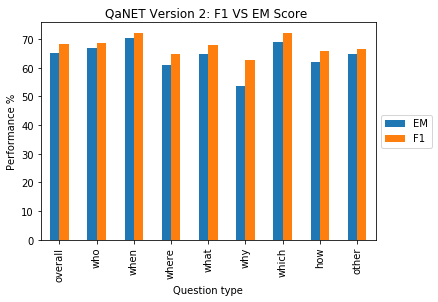

In [ ]:
# Make into pretty graphs 
def graph_em_f1(df, title):
    use = df.drop("AvNA")
    use.T.plot.bar(rot=0)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title(title)
    plt.xticks(rotation=90)
    plt.xlabel("Question type")
    plt.ylabel("Performance %")

graph_em_f1(qanet_v2_qtype, "QaNET Version 2: F1 VS EM Score ")

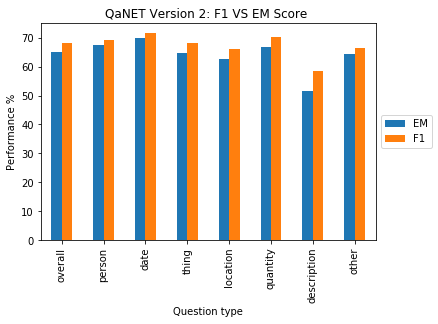

In [ ]:
graph_em_f1(qanet_v2_up_qtype, "QaNET Version 2: F1 VS EM Score ")

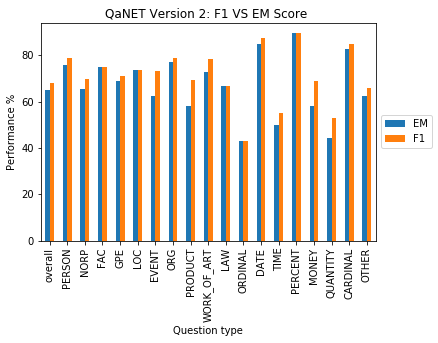

In [ ]:
graph_em_f1(qanet_v2_anstype, "QaNET Version 2: F1 VS EM Score ")

Text(0.5, 1, 'Model Performance (F1 scores) by Question Word')

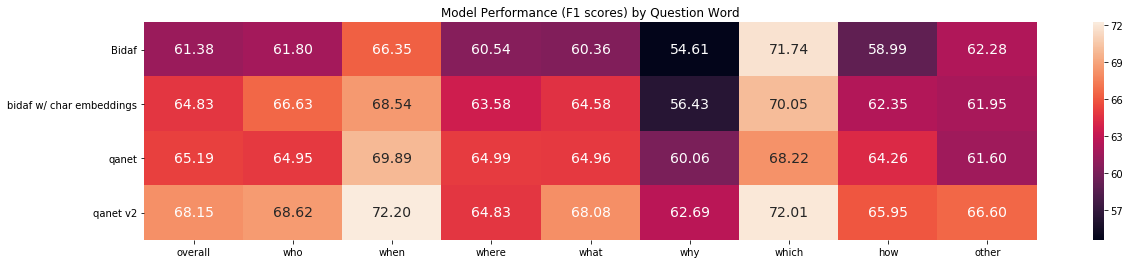

In [ ]:
# Can also make a heatmap
import seaborn as sns 

df_list = [ bidaf_qtype, bidaf_charEmb_qtype, qanet_milestone_qtype, qanet_v2_qtype]
#
f1 = pd.DataFrame()
em = pd.DataFrame()
f1
for df in df_list:
    temp = df[df.index=="F1"].rename(index={})
    f1 = pd.concat([f1, temp], axis=0)
    
    temp2 = df[df.index=="EM"].rename(index={})
    em = pd.concat([em, temp2], axis=0)

f1 = f1.set_axis(["Bidaf", "bidaf w/ char embeddings", "qanet", "qanet v2"], axis=0, inplace=False)
em = em.set_axis(["Bidaf", "bidaf w/ char embeddings", "qanet", "qanet v2"], axis=0, inplace=False)

fig, ax = plt.subplots(figsize=(20,4))         # Sample figsize in inches
sns.heatmap(f1,annot=True,fmt=".2f",annot_kws={"fontsize":14},ax=ax)
plt.title("Model Performance (F1 scores) by Question Word")

Text(0.5, 1, 'Model Performance (EM scores) by Question Word')

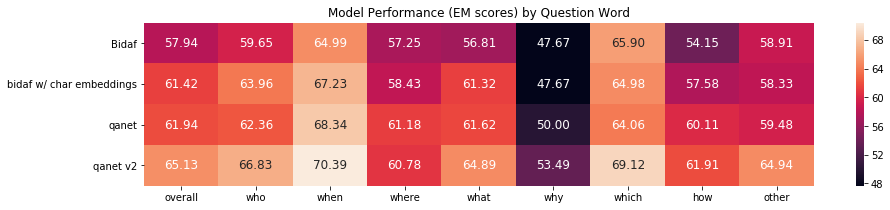

In [ ]:
fig, ax = plt.subplots(figsize=(15,3))         # Sample figsize in inches
sns.heatmap(em,annot=True,fmt=".2f",annot_kws={"fontsize":12},ax=ax)
plt.title("Model Performance (EM scores) by Question Word")

Looking at performance for different buckets of answer lengths, context lengths





Text(0.5, 1, 'Model Performance (F1 scores) by Question Type')

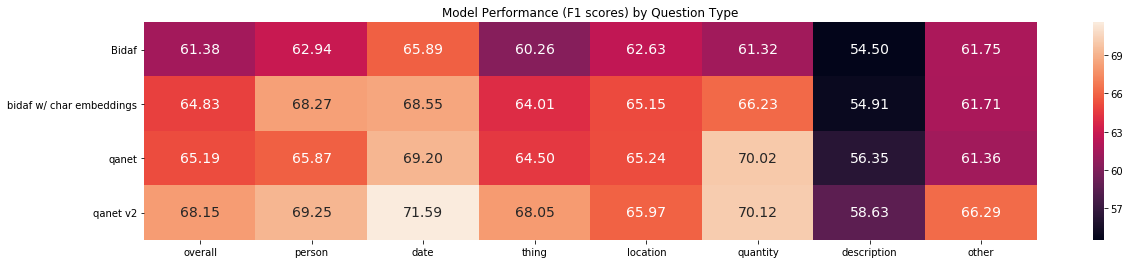

In [ ]:
# Can also make a heatmap
import seaborn as sns 

df_list = [ bidaf_up_qtype, bidaf_charEmb_up_qtype, qanet_milestone_up_qtype, qanet_v2_up_qtype]
#
f1 = pd.DataFrame()
em = pd.DataFrame()
f1
for df in df_list:
    temp = df[df.index=="F1"].rename(index={})
    f1 = pd.concat([f1, temp], axis=0)
    
    temp2 = df[df.index=="EM"].rename(index={})
    em = pd.concat([em, temp2], axis=0)

f1 = f1.set_axis(["Bidaf", "bidaf w/ char embeddings", "qanet", "qanet v2"], axis=0, inplace=False)
em = em.set_axis(["Bidaf", "bidaf w/ char embeddings", "qanet", "qanet v2"], axis=0, inplace=False)

fig, ax = plt.subplots(figsize=(20,4))         # Sample figsize in inches
sns.heatmap(f1,annot=True,fmt=".2f",annot_kws={"fontsize":14},ax=ax)
plt.title("Model Performance (F1 scores) by Question Type")

Text(0.5, 1, 'Model Performance (EM scores) by Question Type')

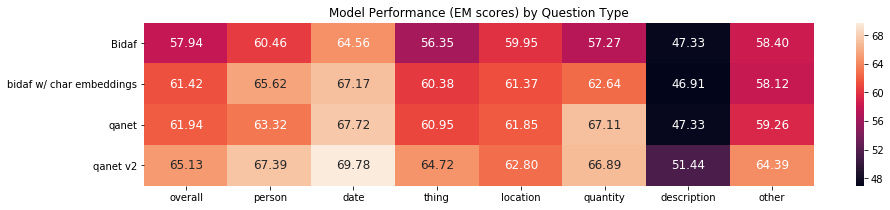

In [ ]:
fig, ax = plt.subplots(figsize=(15,3))         # Sample figsize in inches
sns.heatmap(em,annot=True,fmt=".2f",annot_kws={"fontsize":12},ax=ax)
plt.title("Model Performance (EM scores) by Question Type")

Text(0.5, 1, 'Model Performance (F1 scores) by Answer Entity Type')

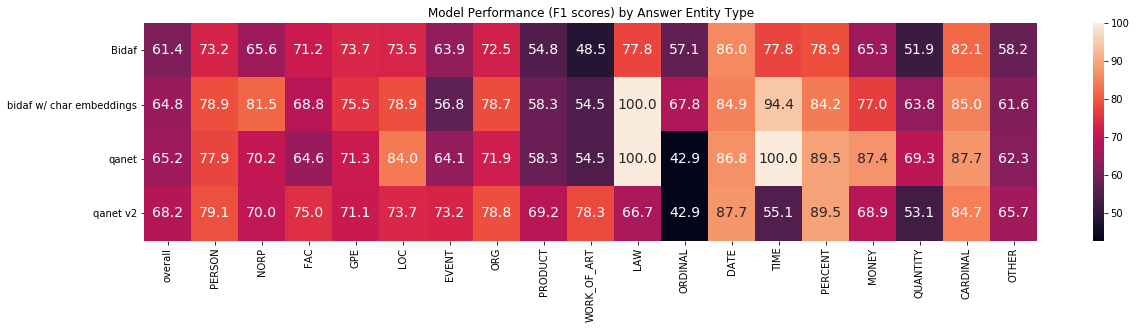

In [ ]:
# Can also make a heatmap
import seaborn as sns 

df_list = [ bidaf_anstype, bidaf_charEmb_anstype, qanet_milestone_anstype, qanet_v2_anstype]
#
f1 = pd.DataFrame()
em = pd.DataFrame()
f1
for df in df_list:
    temp = df[df.index=="F1"].rename(index={})
    f1 = pd.concat([f1, temp], axis=0)
    
    temp2 = df[df.index=="EM"].rename(index={})
    em = pd.concat([em, temp2], axis=0)

f1 = f1.set_axis(["Bidaf", "bidaf w/ char embeddings", "qanet", "qanet v2"], axis=0, inplace=False)
em = em.set_axis(["Bidaf", "bidaf w/ char embeddings", "qanet", "qanet v2"], axis=0, inplace=False)

fig, ax = plt.subplots(figsize=(20,4))         # Sample figsize in inches
sns.heatmap(f1,annot=True,fmt=".1f",annot_kws={"fontsize":14},ax=ax)
plt.title("Model Performance (F1 scores) by Answer Entity Type")

Text(0.5, 1, 'Model Performance (EM scores) by Answer Entity Type')

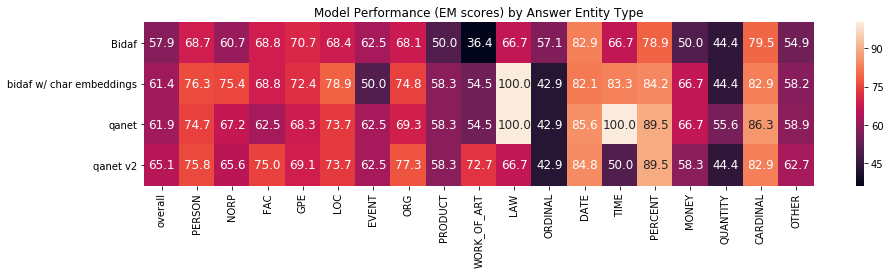

In [ ]:
fig, ax = plt.subplots(figsize=(15,3))         # Sample figsize in inches
sns.heatmap(em,annot=True,fmt=".1f",annot_kws={"fontsize":12},ax=ax)
plt.title("Model Performance (EM scores) by Answer Entity Type")